# Here we'll train some models!

In [21]:
from __future__ import annotations

# Standard library
import sys
import pathlib
import warnings

# Third-party
import numpy as np
import pandas as pd
import yaml
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# --- project paths
PROJ = pathlib.Path().resolve().parent
CFG  = yaml.safe_load(open(PROJ / "conf" / "config.yaml"))
var_types = yaml.safe_load(open(PROJ / "conf" / "variable_types.yaml"))
RAW_DIR = PROJ / CFG["data"]["raw_dir"]
PROC_DIR = PROJ / CFG["data"]["processed_dir"]
numeric_cols = var_types["numeric_variables"]
RULES = yaml.safe_load(open(PROJ/"conf"/"cleaning_rules.yaml"))

if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))

from pipeline.transformers import (AutoTransform) 

PerfWarn = pd.errors.PerformanceWarning
warnings.filterwarnings("ignore", category=PerfWarn)

# ---------- Column groups from config ----------
TYPES = yaml.safe_load(open(PROJ/"conf"/"variable_types.yaml"))

In [2]:
# First read in the file...
df = pd.read_parquet(PROC_DIR / "cbecs_2018_clean.parquet")
cat_cols = [c for c in TYPES["categorical_variables"] if c in df.columns]
num_cols = [c for c in TYPES["numeric_variables"] if c in df.columns]

# Coerce all non-numeric columns to be astype object. Many are actually integers that refer to codes.
df[cat_cols] = df[cat_cols].astype(object)


# Assign X, y 
X = df.drop('LOG_MFBTU', axis=1)
y = df['LOG_MFBTU']

# Split the data into validation, train, and test sets
# e.g., 80/10/10 split
test_size = 0.10
val_size  = 0.10
rand      = 1

# 1) Hold out test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=rand, shuffle=True
)

# 2) From the remainder, carve out validation
val_rel = val_size / (1.0 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_rel, random_state=rand, shuffle=True
    )

# Check and make sure the splits worked as expected...
df.shape
check_shape = X_train.shape[0]+X_test.shape[0]+X_val.shape[0] == df.shape[0]

print(f"Split correctly: {check_shape}")

Split correctly: True


### Let's first train up a very simple baseline to test our models against. We'll try two options: 

1. Predict the mean of the target.
2. Use only `SQFT` as a model feature, as this is a highly predictive feature.

In [18]:
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def baseline_with_sqft(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    feature="num__SQFT_log1p",
    print_lines=True,
    decimals=4,
):
    """
    Two baselines:
      1) Predict the mean of y_train.
      2) LinearRegression with a single feature (default: 'num__SQFT_log1p').

    Prints one summary line per test if print_lines=True, and returns a dict.
    """

    # -- Prepare targets --
    y_train = np.asarray(y_train).ravel()
    y_eval = y_train if y_test is None else np.asarray(y_test).ravel()
    n = int(y_eval.shape[0])

    # ---------- Baseline 1: mean predictor ----------
    yhat_mean_value = float(np.mean(y_train))
    yhat_mean = np.full_like(y_eval, fill_value=yhat_mean_value, dtype=float)
    r2_mean = r2_score(y_eval, yhat_mean)
    resid_mean = y_eval - yhat_mean
    sse_mean = float(np.sum(resid_mean**2))
    mse_mean = float(sse_mean / n)

    mean_results = {
        "yhat_mean": yhat_mean_value,
        "r2": r2_mean,
        "sse": sse_mean,
        "mse": mse_mean,
        "n": n,
    }

    # --- Helper to slice the feature column as 2D ---
    def _col2d(X, feat):
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]
        raise TypeError("For ndarray X, 'feature' must be an int index; "
                        "for DataFrame X, it must be a column name.")

    # ---------- Baseline 2: one-feature LinearRegression ----------
    Xtr_col = _col2d(X_train, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)

    Xev_col = Xtr_col if X_test is None else _col2d(X_test, feature)
    yhat_lr = lr.predict(Xev_col)
    r2_lr = r2_score(y_eval, yhat_lr)
    resid_lr = y_eval - yhat_lr
    sse_lr = float(np.sum(resid_lr**2))
    mse_lr = float(sse_lr / n)

    lr_results = {
        "r2": r2_lr,
        "sse": sse_lr,
        "mse": mse_lr,
        "coef": float(lr.coef_[0]),
        "intercept": float(lr.intercept_),
        "n": n,
    }

    results = {"mean": mean_results, "lr_one_feature": lr_results}

    if print_lines:
        d = decimals
        print(f"BASELINE mean: R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={n}")
        print(f"LR[{feature}]: coef={lr.coef_[0]:.{d}f}  intercept={lr.intercept_:.{d}f}  "
              f"R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={n}")

    return results

# --- Example usage ---
results = baseline_with_sqft(X_train, y_train, X_test, y_test, feature="SQFT_log1p")

BASELINE mean: R2=-0.0075  SSE=2726.6586  MSE=4.2872  n=636
LR[SQFT_log1p]: coef=1.0556  intercept=3.4813  R2=0.8234  SSE=478.0188  MSE=0.7516  n=636


# Run Linear-specific pipeline to finish preparing the data

In [3]:
# import numpy as np
# from sklearn.compose import ColumnTransformer, make_column_selector as selector
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
# from sklearn.base import clone
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, FunctionTransformer
# Numeric pipeline:
# 1) MedianImputer: fill numeric NaNs using  RULES (custom transformer).
# 2) AutoTransform: numeric-only feature engineering/selection step.
# 3) StandardScaler: scale ONLY numeric features to zero mean / unit variance.
num_pipe = Pipeline([
    ("median_imputer",SimpleImputer(strategy='median', add_indicator=True)),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
# OneHotEncoder:
#   - converts categories to 0/1 columns,
#   - handle_unknown="ignore" avoids errors on unseen categories at inference,
#   - sparse_output=False returns a dense array (handy if your model expects dense).
cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer routes columns by dtype:
#   - 'num' receives only numeric columns (np.number) and applies num_pipe.
#   - 'cat' receives object/category/bool columns and applies cat_pipe.
#   - remainder="drop" discards any columns not caught by the selectors
preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, selector(dtype_include=np.number)),
        ("cat", cat_pipe, selector(dtype_include=["object", "category", "bool"])),
    ],
    remainder="drop"
)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

models = {
    "OLS": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 6, 25), cv=5),
    "Lasso": LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4),
    "ElasticNet": ElasticNetCV(cv=5, n_jobs=-1, l1_ratio=[0.2,0.5,0.8],
                               max_iter=100_000, tol=1e-4, selection="cyclic", random_state=42),
}

for name, m in models.items():
    # IMPORTANT: fresh (unfitted) preproc inside the pipeline for each CV split
    pipe = Pipeline([("preproc", clone(preproc)), ("model", m)])
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1).mean()
    print(f"{name}: {score:.3f}")

OLS: -752703983480718592.000
Ridge: 0.924
Lasso: 0.925
ElasticNet: 0.925


In [4]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)



lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4))
])

enet = Pipeline([
    ("preproc", clone(preproc)),
    ("model", ElasticNetCV(cv=5, n_jobs=-1,
                           l1_ratio=[0.0001, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8, 0.9999],
                           max_iter=100_000, tol=1e-4, selection="cyclic",
                           random_state=1))
])

s_lasso = cross_val_score(lasso, X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)
s_enet  = cross_val_score(enet,  X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)

print(f"Lasso  mean={s_lasso.mean():.3f} ± {s_lasso.std():.3f}")
print(f"ENet   mean={s_enet.mean():.3f}  ± {s_enet.std():.3f}")
print(f"Δ(EN-Lasso) = {(s_enet - s_lasso).mean():.4f}")

Lasso  mean=0.924 ± 0.007
ENet   mean=0.924  ± 0.007
Δ(EN-Lasso) = -0.0000


I'll pick Lasso as it's a simpler model and has fewer hyperparameters to tune. It also seems like there's essentially no performance benefit to choosing ENet. Now I'll do a finer tuning pass on the Lasso. 

In [5]:
inner = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", LassoCV(cv=inner, n_jobs=-1, max_iter=200_000, tol=1e-4, selection="cyclic")) #Increase number of iterations allowed for finer resolution screening if necessary
])

out = cross_validate(lasso, X_train, y_train, cv=rkf,
                     scoring="r2", n_jobs=-1, return_estimator=True)

alphas = [est.named_steps["model"].alpha_ for est in out["estimator"]]
alpha_star = float(np.median(alphas))

Now I'll use the best-selected alpha to tune up a final model.

In [32]:
final_lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", Lasso(alpha=alpha_star, max_iter=200_000, tol=1e-4, selection="cyclic"))
]).fit(X_train, y_train)

# Predictions
y_pred = final_lasso.predict(X_test)

# Metrics
r2_test = r2_score(y_test, y_pred)
residuals = y_test - y_pred
sse = np.sum(residuals ** 2)              # sum of squared errors
mse = sse / len(y_test)                   # mean squared error

print(f"R²  = {r2_test:.4f}")
print(f"SSE = {sse:.4f}")
print(f"MSE = {mse:.4f}")

R²  = 0.9364
SSE = 172.0816
MSE = 0.2706


In [19]:
import numpy as np
import pandas as pd

# grab steps
pre = final_lasso.named_steps["preproc"]
mod = final_lasso.named_steps["model"]

# 1) feature names after preprocessing
# Works for sklearn >= 1.0; otherwise see fallback below.
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # ---- Fallback for older sklearn: build names manually ----
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if trans == "passthrough":
            # cols may be a list/array of column names or indices
            if isinstance(cols, slice):
                raise ValueError("Slice columns not supported in this fallback.")
            feature_names.extend([str(c) for c in cols])
        else:
            # try to get names from the transformer itself (e.g., OneHotEncoder)
            if hasattr(trans, "get_feature_names_out"):
                # if cols are indices, convert to strings
                base = np.array(cols).astype(str)
                feature_names.extend(trans.get_feature_names_out(base))
            else:
                # last resort: use the transformer name as a prefix
                if isinstance(cols, (list, np.ndarray)):
                    feature_names.extend([f"{name}__{c}" for c in cols])
                else:
                    feature_names.append(f"{name}")

feature_names = np.asarray(feature_names)

# 2) coefficients (already aligned with transformed columns)
coefs = mod.coef_.ravel()

# 3) tidy DataFrame
coef_df = pd.DataFrame(
    {
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "nonzero": coefs != 0.0,
    }
).sort_values("abs_coef", ascending=False).reset_index(drop=True)


coef_df.head(10)

,feature,coef,abs_coef,nonzero
0,num__SQFT_log1p,1.333799,1.333799,True
1,cat__PBA_4,0.393964,0.393964,True
2,cat__PRHT1_1,-0.383009,0.383009,True
3,cat__PBA_6,0.321376,0.321376,True
4,cat__PBA_5,-0.288161,0.288161,True
5,cat__BOOSTWT_nan,-0.286047,0.286047,True
6,cat__ENRGYPLN_nan,-0.286012,0.286012,True
7,cat__WHRECOV_nan,-0.267166,0.267166,True
8,cat__NGUSED_1,0.210005,0.210005,True
9,cat__VAV_nan,-0.175660,0.175660,True


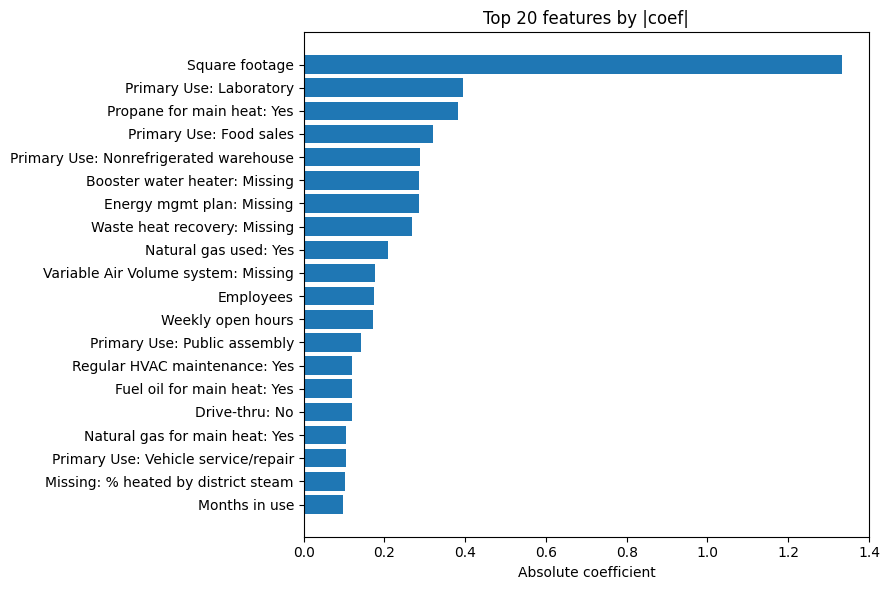

In [31]:
# Mapping from feature strings (your first 20) to readable labels
readable_map = {
    "num__SQFT_log1p": "Square footage",
    "cat__PBA_4": "Primary Use: Laboratory",
    "cat__PRHT1_1": "Propane for main heat: Yes",
    "cat__PBA_6": "Primary Use: Food sales",
    "cat__PBA_5": "Primary Use: Nonrefrigerated warehouse",
    "cat__BOOSTWT_nan": "Booster water heater: Missing",
    "cat__ENRGYPLN_nan": "Energy mgmt plan: Missing",
    "cat__WHRECOV_nan": "Waste heat recovery: Missing",
    "cat__NGUSED_1": "Natural gas used: Yes",
    "cat__VAV_nan": "Variable Air Volume system: Missing",
    "num__NWKER_log1p": "Employees",
    "num__WKHRS_sqrt": "Weekly open hours",
    "cat__PBA_13": "Primary Use: Public assembly",
    "cat__MAINT_1.0": "Regular HVAC maintenance: Yes",
    "cat__FKHT1_1": "Fuel oil for main heat: Yes",
    "cat__DRVTHRU_0.0": "Drive-thru: No",
    "cat__NGHT1_1": "Natural gas for main heat: Yes",
    "cat__PBAPLUS_46": "Primary Use: Vehicle service/repair",
    "num__missingindicator_STHWP_ST": "Missing: % heated by district steam",
    "num__MONUSE": "Months in use",
}

# Take first 20 rows from your existing coef_df
top20 = coef_df.head(20).copy()
top20["readable"] = top20["feature"].map(readable_map).fillna(top20["feature"])

# Bar plot of absolute coefficients
plt.figure(figsize=(9, 6))
y = np.arange(len(top20))
plt.barh(y, top20["abs_coef"].values)
plt.yticks(y, top20["readable"].values)
plt.xlabel("Absolute coefficient")
plt.title("Top 20 features by |coef|")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

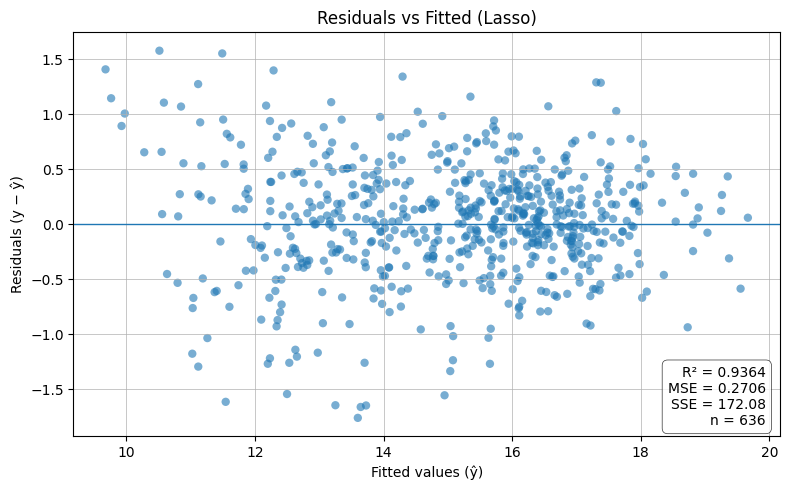

In [33]:
r2 = r2_score(y_test, y_pred)
resid = y_test - y_pred
sse = float(np.sum(resid**2))
mse = float(sse / len(y_test))

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, resid, alpha=0.6, edgecolor="none")
plt.axhline(0, linewidth=1)
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("Residuals (y − ŷ)")
plt.title("Residuals vs Fitted (Lasso)")
plt.grid(True, linewidth=0.5)

# Stats box
text = f"R² = {r2:.4f}\nMSE = {mse:.4f}\nSSE = {sse:.2f}\nn = {len(y_test)}"
plt.gca().text(
    0.98, 0.02, text,
    transform=plt.gca().transAxes,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, linewidth=0.5)
)

plt.tight_layout()
plt.show()

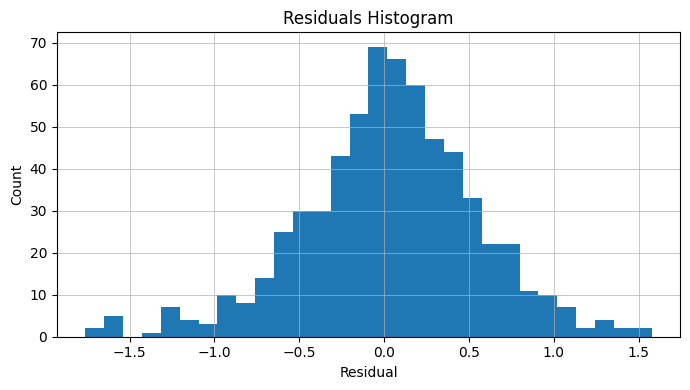

In [34]:
plt.figure(figsize=(7, 4))
plt.hist(resid, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

### Quick thoughts about the above:
When I initially fit an unregularized OLS model, performance collapsed (R² ≈ -8×10²³). This indicates severe multicollinearity in the expanded feature space — a common issue after one-hot encoding. I therefore implemented Ridge and Lasso regularization, which stabilized the solution and improved cross-validated R² to ~0.92. I considered manually examining collinearity of features and pruning appropriately, but, given the width of this dataset, I opted for regularization instead.

In [7]:
# ============================================================
# Ridge vs Lasso vs ElasticNet — metrics only (no decisions)
# Proper 5-fold OUTER CV for fair comparison.
# Assumes: X_train_proc, y_train (and optionally X_test_proc).
# ============================================================

import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.exceptions import ConvergenceWarning
import warnings

# Keep output tidy
warnings.filterwarnings("ignore", category=ConvergenceWarning)
np.set_printoptions(suppress=True)

# Show data shape (handy for context in your notes)
n_samples, n_features = X_train_proc.shape
print(f"Data: {n_samples} rows × {n_features} features\n")

# Outer CV = fair/unbiased estimate for each model
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Define models (each does its own INNER CV to tune hyperparameters)
ridge = RidgeCV(alphas=np.logspace(-4, 6, 25), cv=5)

lasso = LassoCV(
    cv=5,
    n_alphas=80,
    n_jobs=-1,
    max_iter=100_000,
    tol=1e-4,
    random_state=1
)

enet = ElasticNetCV(
    l1_ratio=[0.2, 0.5, 0.8],            # ridge-ish, middle, lasso-ish
    alphas=np.logspace(-4, 3, 40),
    cv=5,
    n_jobs=-1,
    max_iter=100_000,
    tol=1e-4,
    selection="cyclic",
    random_state=1
)

models = [("Ridge", ridge), ("Lasso", lasso), ("ElasticNet", enet)]

def evaluate_and_print(name, est):
    """
    1) Scores with OUTER CV (proper estimate).
    2) Fit once on all training data so we can print chosen hyperparameters and sparsity.
    """
    print(f"--- {name} ---")
    # Outer CV scores (the estimator tunes on inner CV inside each fold)
    scores = cross_val_score(est, X_train_proc, y_train,
                             cv=outer_cv, scoring="r2", n_jobs=-1)
    print(f"CV R^2 (outer 5-fold): mean={scores.mean():.3f}, std={scores.std():.3f}")

    # Fit on full training set to report chosen hyperparameters
    est.fit(X_train_proc, y_train)

    if hasattr(est, "alpha_"):
        print(f"Chosen alpha (after inner CV): {est.alpha_:.6g}")
    if hasattr(est, "l1_ratio_"):
        print(f"Chosen l1_ratio (ElasticNet only): {est.l1_ratio_:.2f}")

    if hasattr(est, "coef_") and est.coef_ is not None:
        nonzero = int(np.count_nonzero(est.coef_))
        total   = int(est.coef_.size)
        print(f"Non-zero coefficients (sparsity): {nonzero} / {total}")

    print()  # blank line for readability

# Run and print metrics for all three
evaluate_and_print("Ridge", ridge)
evaluate_and_print("Lasso", lasso)
evaluate_and_print("ElasticNet", enet)

# (In your next markdown cell, explain which you chose and why.)

NameError: name 'X_train_proc' is not defined

In [ ]:
# ---- 2×2 attribution test: MedianImputer vs AutoTransform (clean CV only) ----

import time, numpy as np, pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score

# --- Helpers from earlier runs (keep consistent) ---
class CountWrapper(BaseEstimator, TransformerMixin):
    count = 0
    def __init__(self, base): self.base = base
    def fit(self, X, y=None):
        CountWrapper.count += 1
        return self.base.fit(X, y)
    def transform(self, X): return self.base.transform(X)
    def get_feature_names_out(self, *args, **kwargs):
        if hasattr(self.base, "get_feature_names_out"):
            return self.base.get_feature_names_out(*args, **kwargs)
        raise AttributeError("base has no get_feature_names_out")

class EnsureStrColumns(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.copy()
            X.columns = X.columns.map(str)
        return X

def build_preproc(use_custom_median: bool, use_auto: bool):
    # numeric branch
    steps_num = []
    if use_custom_median:
        steps_num.append(("median_imputer", MedianImputer(RULES["impute_rules"])))
    # Always keep a safety fallback so numerics never carry NaNs
    steps_num.append(("fallback_imputer", SimpleImputer(strategy="median")))
    if use_auto:
        steps_num.append(("auto", CountWrapper(AutoTransform(scoring="r2", n_jobs=-1, suffix_identity=False))))
        steps_num.append(("ensure_str_cols", EnsureStrColumns()))
    # If AutoTransform is OFF, we still ensure names are strings to keep sklearn happy
    if not use_auto:
        steps_num.append(("ensure_str_cols", EnsureStrColumns()))
    steps_num.append(("scaler", StandardScaler()))
    num_pipe = Pipeline(steps_num)

    # categorical branch (same for all variants)
    cat_pipe = Pipeline([
        ("cat_imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("to_str", FunctionTransformer(lambda X: X.astype(str))),
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
        ("scale", MaxAbsScaler()),
    ])

    return ColumnTransformer(
        transformers=[
            ("num", num_pipe, selector(dtype_include=np.number)),
            ("cat", cat_pipe, selector(dtype_include=["object", "category", "bool"])),
        ],
        remainder="drop"
    )

def run_clean_cv(label, preproc, lasso_cv, X, y, outer_folds=3):
    cv = KFold(n_splits=outer_folds, shuffle=True, random_state=1)
    CountWrapper.count = 0
    t0 = time.perf_counter()
    scores = []
    for i, (tr, va) in enumerate(cv.split(X, y), start=1):
        pipe = Pipeline([("preproc", clone(preproc)), ("model", clone(lasso_cv))])
        Xtr, Xva = (X.iloc[tr] if hasattr(X, "iloc") else X[tr],
                    X.iloc[va] if hasattr(X, "iloc") else X[va])
        ytr, yva = (y.iloc[tr] if hasattr(y, "iloc") else y[tr],
                    y.iloc[va] if hasattr(y, "iloc") else y[va])
        pipe.fit(Xtr, ytr)
        pred = pipe.predict(Xva)
        scores.append(r2_score(yva, pred))
    elapsed = time.perf_counter() - t0
    print(f"[{label}] R² mean={np.mean(scores):.3f} ± {np.std(scores):.3f} | "
          f"time={elapsed:.1f}s | AutoTransform.fit calls={CountWrapper.count}")
    return np.mean(scores), np.std(scores), elapsed, CountWrapper.count

# ---- LassoCV config (same across all variants) ----
ALPHAS   = np.logspace(-5, 0, 50)
MAX_ITER = 12000     # bump to calm convergence warnings
INNER    = 3
lasso_cv = LassoCV(
    alphas=ALPHAS, cv=INNER, max_iter=MAX_ITER,
    tol=1e-4, selection="cyclic", n_jobs=-1, random_state=1
)

print("=== Attribution test: does the gap come from MedianImputer or AutoTransform? ===")
# Variants:
# A) Custom Median + AutoTransform
pre_A = build_preproc(use_custom_median=True,  use_auto=True)
# B) Custom Median + NO AutoTransform
pre_B = build_preproc(use_custom_median=True,  use_auto=False)
# C) NO Custom Median (fallback only) + AutoTransform
pre_C = build_preproc(use_custom_median=False, use_auto=True)
# D) NO Custom Median (fallback only) + NO AutoTransform
pre_D = build_preproc(use_custom_median=False, use_auto=False)

# Run clean CV for each
res = {}
res["A_custom+auto"]   = run_clean_cv("A  (custom median + AutoTransform)", pre_A, lasso_cv, X_train, y_train)
res["B_custom+noauto"] = run_clean_cv("B  (custom median + NO AutoTransform)", pre_B, lasso_cv, X_train, y_train)
res["C_fallback+auto"] = run_clean_cv("C  (fallback-only + AutoTransform)", pre_C, lasso_cv, X_train, y_train)
res["D_fallback+noauto"]=run_clean_cv("D  (fallback-only + NO AutoTransform)", pre_D, lasso_cv, X_train, y_train)

# Simple attribution readouts
def r2_of(key): return res[key][0]
print("\n=== Attribution summary (higher R² is better) ===")
print(f"A vs B (effect of AutoTransform w/ custom median):   ΔR² = {r2_of('A_custom+auto') - r2_of('B_custom+noauto'):+.3f}")
print(f"C vs D (effect of AutoTransform w/ fallback only):  ΔR² = {r2_of('C_fallback+auto') - r2_of('D_fallback+noauto'):+.3f}")
print(f"A vs C (effect of custom median when AutoTransform on):  ΔR² = {r2_of('A_custom+auto') - r2_of('C_fallback+auto'):+.3f}")
print(f"B vs D (effect of custom median when AutoTransform off): ΔR² = {r2_of('B_custom+noauto') - r2_of('D_fallback+noauto'):+.3f}")

Benchmark